## sliding window video {.unnumbered}

Import packages and stuff.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()  # datetime converter for a matplotlib
import seaborn as sns
sns.set(style="ticks", font_scale=1.5)
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import scipy as sp
import json
import requests
import os
import subprocess
from tqdm import tqdm
from scipy import signal

# avoid "SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame."
pd.options.mode.chained_assignment = None  # default='warn'

Download  data from the [IMS](https://ims.gov.il/en/data_gov){target="_blank"} using an API.

In [6]:
# read token from file
with open('../archive/IMS-token.txt', 'r') as file:
    TOKEN = file.readline()
# 28 = SHANI station
STATION_NUM = 28
start = "2022/01/01"
end = "2022/01/07"
filename = 'shani_2022_january.json'

# check if the JSON file already exists
# if so, then load file
if os.path.exists(filename):
    with open(filename, 'r') as json_file:
        data = json.load(json_file)
else:
    # make the API request if the file doesn't exist
    url = f"https://api.ims.gov.il/v1/envista/stations/{STATION_NUM}/data/?from={start}&to={end}"
    headers = {'Authorization': f'ApiToken {TOKEN}'}
    response = requests.get(url, headers=headers)
    data = json.loads(response.text.encode('utf8'))
    
    # save the JSON data to a file
    with open(filename, 'w') as json_file:
        json.dump(data, json_file)
# show data to see if it's alright
# data

Load and process data.

In [8]:
df = pd.json_normalize(data['data'],record_path=['channels'], meta=['datetime'])
df['date'] = (pd.to_datetime(df['datetime'])
                .dt.tz_localize(None)  # ignores time zone information
             )
df = df.pivot(index='date', columns='name', values='value')
df

name,Grad,RH,Rain,STDwd,TD,TDmax,TDmin,TG,TW,Time,WD,WDmax,WS,WS1mm,WSmax,Ws10mm
date,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,0.0,77.0,0.0,10.3,11.2,11.2,11.1,10.7,-9999.0,2354.0,75.0,64.0,5.0,6.0,7.0,5.5
2022-01-01 00:10:00,0.0,77.0,0.0,11.2,11.2,11.2,11.1,10.8,-9999.0,1.0,77.0,84.0,4.7,5.5,6.6,4.9
2022-01-01 00:20:00,0.0,75.0,0.0,10.0,11.4,11.5,11.2,10.9,-9999.0,20.0,80.0,83.0,5.1,6.2,8.0,5.1
2022-01-01 00:30:00,0.0,74.0,0.0,9.6,11.5,11.5,11.4,11.0,-9999.0,22.0,76.0,74.0,4.8,5.8,7.3,5.0
2022-01-01 00:40:00,0.0,73.0,0.0,9.1,11.6,11.7,11.5,11.1,-9999.0,34.0,74.0,64.0,4.8,5.7,7.2,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-06 23:10:00,0.0,36.0,0.0,16.1,11.6,12.0,11.1,6.8,-9999.0,2310.0,144.0,126.0,0.7,1.6,2.0,0.7
2022-01-06 23:20:00,0.0,35.0,0.0,10.1,12.1,12.3,11.9,6.3,-9999.0,2320.0,118.0,116.0,1.5,1.9,2.3,1.5
2022-01-06 23:30:00,0.0,36.0,0.0,7.1,12.4,12.6,11.9,7.3,-9999.0,2330.0,113.0,116.0,2.5,3.0,3.3,2.5


Define useful functions.

In [12]:
def concise(ax):
    """
    Let python choose the best xtick labels for you
    """
    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

# dirty trick to have dates in the middle of the 24-hour period
# make minor ticks in the middle, put the labels there!
# from https://matplotlib.org/stable/gallery/ticks/centered_ticklabels.html

def center_dates(ax):
    # show day of the month + month abbreviation. see full option list here:
    # https://strftime.org
    date_form = DateFormatter("%d %b")
    # major ticks at midnight, every day
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(date_form)
    # minor ticks at noon, every day
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=[12]))
    # erase major tick labels
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    # set minor tick labels as define above
    ax.xaxis.set_minor_formatter(date_form)
    # completely erase minor ticks, center tick labels
    for tick in ax.xaxis.get_minor_ticks():
        tick.tick1line.set_markersize(0)
        tick.tick2line.set_markersize(0)
        tick.label1.set_horizontalalignment('center')

def center_dates_two_panels(ax0, ax1):
    # show day of the month + month abbreviation. see full option list here:
    date_form = DateFormatter("%d %b")
    # major ticks at midnight, every day
    ax0.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax1.xaxis.set_major_formatter(date_form)
    # minor ticks at noon, every day
    ax1.xaxis.set_minor_locator(mdates.HourLocator(byhour=[12]))
    # erase major tick labels
    ax1.xaxis.set_major_formatter(ticker.NullFormatter())
    # set minor tick labels as define above
    ax1.xaxis.set_minor_formatter(date_form)
    # completely erase minor ticks, center tick labels
    for tick in ax0.xaxis.get_minor_ticks():
        tick.tick1line.set_markersize(0)
        tick.tick2line.set_markersize(0)
    for tick in ax1.xaxis.get_minor_ticks():
        tick.tick1line.set_markersize(0)
        tick.tick2line.set_markersize(0)
        tick.label1.set_horizontalalignment('center')

We don't need the full month, let's cut the dataframe to fewer days.

In [12]:
start = "2022-01-01 00:00:00"
end = "2022-01-06 23:50:00"
df = df.loc[start:end]

We now redefine a narrower window, this will be the graph's xlimits. We leave the dataframe as is, because we will need some data outside the graph's limits.

In [13]:
start = "2022-01-02 00:00:00"
end = "2022-01-05 23:50:00"

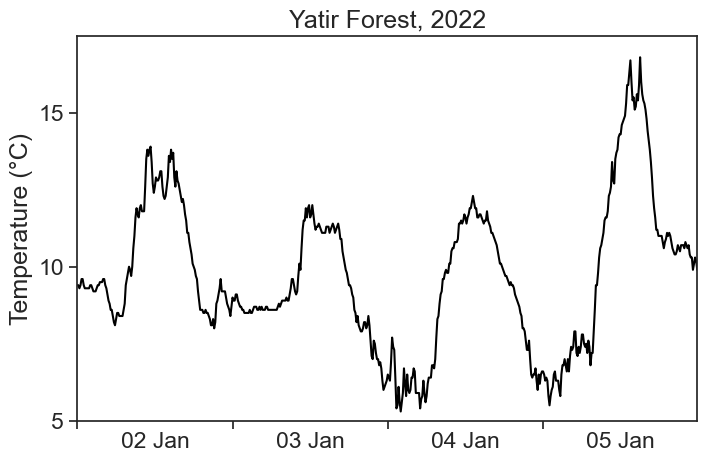

In [15]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(df.loc[start:end, 'TD'], color='black')
ax.set(ylim=[5, 17.5],
       xlim=[start, end],
       ylabel="Temperature (°C)",
       title="Yatir Forest, 2022",
       yticks=[5,10,15])
center_dates(ax)
fig.savefig("sliding_YF_temperature_2022.png")

Looks good. Let's move on.

## Rectangular kernel

100%|█████████▉| 604/605 [05:27<00:00,  1.85iteration/s]


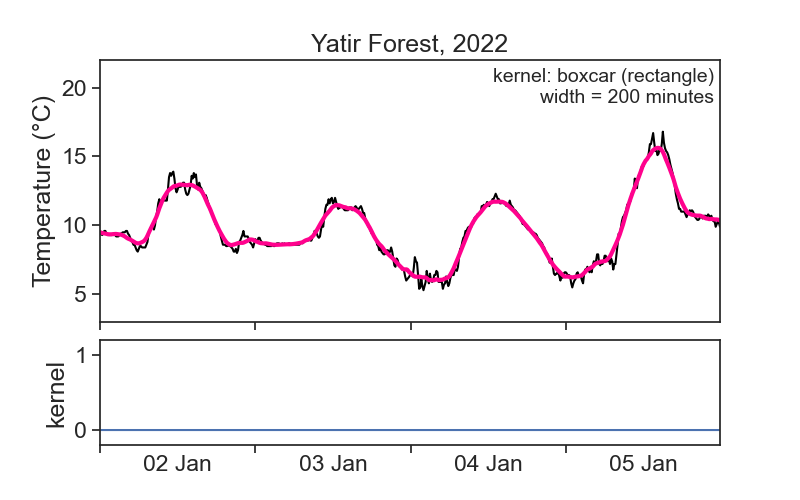

In [23]:
%matplotlib widget
fig, ax = plt.subplots(2, 1, figsize=(8,5), sharex=True,
                       gridspec_kw={'height_ratios':[1,0.4], 'hspace':0.1})

class Lines:
    """
    empty class, later will be populated with graph objects.
    this is useful to draw and erase lines on demand.
    """
    pass
lines = Lines()

# rename axes for convenience
ax0 = ax[0]
ax1 = ax[1]
# sm = df['TD'].rolling(10, center=True).mean()
# ga = df['TD'].rolling(10, center=True, win_type="gaussian").mean(std=100.0)

# set graph y limits
ylim = [3, 22]
# choose here windown width in minutes
window_width_min = 200.0
window_width_min_integer = int(window_width_min)  # same but integer
window_width_int = int(window_width_min // 10 + 1)  # window width in points
N = len(df)  # df length
# time range over which the kernel will slide
# starts at "start", minus the width of the window,
# minus half an hour, so that the window doesn't start sliding right away at the beginning of the video
# ends an hour after the window has finished sliding
t_swipe = pd.date_range(start=pd.to_datetime(start) - pd.Timedelta(minutes=window_width_min) - pd.Timedelta(minutes=30),
                        end=pd.to_datetime(end) + pd.Timedelta(minutes=60),
                        freq="10min")
# starting time
t0 = t_swipe[0]
# show sliding window on the top panel as a light blue shade
lines.fill_bet = ax0.fill_between([t0, t0 + pd.Timedelta(minutes=window_width_min)],
                                           y1=ylim[0], y2=ylim[1], alpha=0.1, zorder=-1)
# this is our "boxcart" kernel (a rectangle)
kernel_rect = np.ones(window_width_int)
# calculate the moving average with "kernel_rect" as weights
# this is the same as a convolution, which is just faster to compute
df.loc[:, 'con'] = np.convolve(df['TD'].values, kernel_rect, mode='same') / len(kernel_rect)
# create a new column for the kernel, fill it with zeros
df['kernel_plus'] = 0.0
# populate the kernel column with the window at the very beginning
df.loc[t0: t0 + pd.Timedelta(minutes=window_width_min), 'kernel_plus'] = kernel_rect
# plot kernel on the bottom panel
lines.kernel_line, = ax1.plot(df['kernel_plus'])
# plot temperature on the top panel
ax0.plot(df.loc[start:end, 'TD'], color="black")
# make temperature look gray when inside the sliding window
lines.gray_line, = ax0.plot(df.loc[df['kernel_plus']==1.0, 'TD'],
                     color=[0.6]*3, lw=3)
# calculate the middle of the sliding window
window_middle = t0 + pd.Timedelta(minutes=window_width_min/2)
# plot a pink line showing the result of the moving average
# from the beginning to the middle of the sliding window
lines.pink_line, = ax0.plot(df.loc[start:window_middle, 'con'], color="xkcd:hot pink", lw=3)
# emphasize the location of the middle on the window with a circle
lines.pink_circle, = ax0.plot([window_middle], [df.loc[window_middle, 'con']],
         marker='o', markerfacecolor="None", markeredgecolor="xkcd:dark pink", markeredgewidth=2,
         markersize=8)
# some explanation
ax0.text(0.99, 0.97, f"kernel: boxcar (rectangle)\nwidth = {window_width_min:.0f} minutes", transform=ax0.transAxes,
         horizontalalignment='right', verticalalignment='top',
         fontsize=14)
# axis tweaking
ax0.set(ylim=ylim,
        xlim=[start, end],
        ylabel="Temperature (°C)",
        yticks=[5,10,15,20],
        title="Yatir Forest, 2022")
ax1.set(ylim=[-0.2, 1.2],
        xlim=[start, end],
        ylabel="kernel"
       )
# adjust dates on both panels as defined before
center_dates_two_panels(ax0, ax1)

def update_swipe(k, lines):
    """
    updates both panels, given the index k along which the window is sliding
    """
    # left side of the sliding window
    t0 = t_swipe[k]
    # middle position
    window_middle = t0 + pd.Timedelta(minutes=window_width_min/2)
    # erase previous blue shade on the top graph
    lines.fill_bet.remove()
    # fill again the blue shade in the updated window position
    lines.fill_bet = ax0.fill_between([t0, t0 + pd.Timedelta(minutes=window_width_min)],
                                               y1=ylim[0], y2=ylim[1], alpha=0.1, zorder=-1, color="tab:blue")
    # update pink curve
    lines.pink_line.set_data(df[start:window_middle].index,
                             df.loc[start:window_middle, 'con'].values)
    # update pink circle
    lines.pink_circle.set_data([window_middle], [df.loc[window_middle, 'con']])
    # update the kernel in its current position
    lines.kernel_rect = np.ones(window_width_int)
    df.loc[:, 'kernel_plus'] = 0.0
    df.loc[t0: t0 + pd.Timedelta(minutes=window_width_min), 'kernel_plus'] = kernel_rect
    # update gray line
    lines.gray_line.set_data(df.loc[df['kernel_plus']==1.0, 'TD'].index,
                             df.loc[df['kernel_plus']==1.0, 'TD'].values)
    # update kernel line
    lines.kernel_line.set_data(df['kernel_plus'].index, df['kernel_plus'].values)

# create a tqdm progress bar
progress_bar = tqdm(total=len(t_swipe), unit="iteration")
# loop over all sliding indices, update graph and then save it
for fignum, i in enumerate(np.arange(0, len(t_swipe)-1, 1)):
    update_swipe(i, lines)
    fig.savefig(f"pngs/boxcar{window_width_min_integer}/boxcar_{window_width_min_integer}min_{fignum:03}.png", dpi=600)
    # update the progress bar
    progress_bar.update(1)
# close the progress bar
progress_bar.close()

Combine all saved images into one mp4 video.

In [24]:
# Define the path to your PNG images
pngs_path = f"pngs/boxcar{window_width_min_integer}"
pngs_name = f"boxcar_{window_width_min_integer}min_%03d.png"

# Define the output video file path
video_output = f"output{window_width_min_integer}.mp4"

# Use ffmpeg to create a video from PNG images
# desired framerate. choose 24 if you don't know what to do
fr = 12
# run command
ffmpeg_cmd = f"ffmpeg -framerate {fr} -i {pngs_path}/{pngs_name} -c:v libx264 -vf fps={fr} {video_output}"
subprocess.run(ffmpeg_cmd, shell=True)

ffmpeg version 6.0 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 14.0.3 (clang-1403.0.22.14.1)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/6.0 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disab

CompletedProcess(args='ffmpeg -framerate 12 -i pngs/boxcar200/boxcar_200min_%03d.png -c:v libx264 -vf fps=12 output200.mp4', returncode=0)

The following code does exactly as you see above, but it is not well commented. You are an intelligent person, you'll figure this out.

## Triangular kernel

100%|█████████▉| 634/635 [05:35<00:00,  1.89iteration/s]


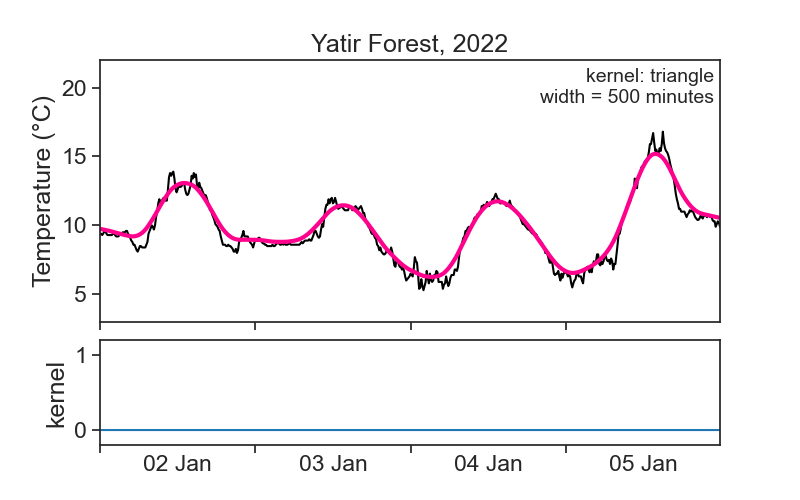

In [25]:
%matplotlib widget
fig, ax = plt.subplots(2, 1, figsize=(8,5), sharex=True,
                       gridspec_kw={'height_ratios':[1,0.4], 'hspace':0.1})

class Lines:
    pass
lines = Lines()

ax0 = ax[0]
ax1 = ax[1]
ylim = [3, 22]
window_width_min = 500.0
window_width_int = int(window_width_min / 10) + 1
N = len(df)
t_swipe = pd.date_range(start=pd.to_datetime(start) - pd.Timedelta(minutes=window_width_min) - pd.Timedelta(minutes=30),
                        end=pd.to_datetime(end) + pd.Timedelta(minutes=60),
                        freq="10min")
t0 = t_swipe[200]
window_middle = t0 + pd.Timedelta(minutes=window_width_min/2)
# fill between blue shade, plot kernel
lines.fill_bet = ax0.fill_between([t0, t0 + pd.Timedelta(minutes=window_width_min)],
                                           y1=ylim[0], y2=ylim[1], alpha=0.1, zorder=-1)
half_triang = np.arange(1, window_width_int/2+1, 1)
kernel_triang = np.hstack([half_triang, half_triang[-2::-1]])
kernel_triang = kernel_triang / kernel_triang.max()
df.loc[:, 'con'] = np.convolve(df['TD'].values, kernel_triang, mode='same') / len(kernel_triang) * 2
df['kernel_plus'] = 0.0
df.loc[t0: t0 + pd.Timedelta(minutes=window_width_min), 'kernel_plus'] = kernel_triang
lines.kernel_line, = ax1.plot(df['kernel_plus'], color="tab:blue")
ax0.plot(df.loc[start:end, 'TD'], color="black")
lines.gray_line, = ax0.plot(df.loc[df['kernel_plus']!=0.0, 'TD'],
                     color=[0.6]*3, lw=3)
lines.pink_line, = ax0.plot(df.loc[start:window_middle, 'con'], color="xkcd:hot pink", lw=3)
lines.pink_circle, = ax0.plot([window_middle], [df.loc[window_middle, 'con']],
         marker='o', markerfacecolor="None", markeredgecolor="xkcd:dark pink", markeredgewidth=2,
         markersize=8)
ax0.text(0.99, 0.97, f"kernel: triangle\nwidth = {window_width_min:.0f} minutes", transform=ax0.transAxes,
         horizontalalignment='right', verticalalignment='top',
         fontsize=14)
ax0.set(ylim=ylim,
        xlim=[start, end],
        ylabel="Temperature (°C)",
        yticks=[5,10,15,20],
        title="Yatir Forest, 2022")
ax1.set(ylim=[-0.2, 1.2],
        xlim=[start, end],
        ylabel="kernel"
       )
center_dates_two_panels(ax0, ax1)

def update_swipe(k, lines):
    t0 = t_swipe[k]
    window_middle = t0 + pd.Timedelta(minutes=window_width_min/2)
    lines.fill_bet.remove()
    lines.fill_bet = ax0.fill_between([t0, t0 + pd.Timedelta(minutes=window_width_min)],
                                               y1=ylim[0], y2=ylim[1], alpha=0.1, zorder=-1, color="tab:blue")
    lines.pink_line.set_data(df[start:window_middle].index,
                             df.loc[start:window_middle, 'con'].values)
    lines.pink_circle.set_data([window_middle], [df.loc[window_middle, 'con']])
    lines.kernel_rect = np.ones(window_width_int)
    df['kernel_plus'] = 0.0
    df.loc[t0: t0 + pd.Timedelta(minutes=window_width_min), 'kernel_plus'] = kernel_triang
    lines.gray_line.set_data(df.loc[df['kernel_plus']!=0.0,'TD'].index,
                             df.loc[df['kernel_plus']!=0.0,'TD'].values)
    lines.kernel_line.set_data(df['kernel_plus'].index, df['kernel_plus'].values)

progress_bar = tqdm(total=len(t_swipe), unit="iteration")
for fignum, i in enumerate(np.arange(0, len(t_swipe)-1, 1)):
    update_swipe(i, lines)
    fig.savefig(f"pngs/triangle/triangle_{fignum:03}.png", dpi=600)
    # update the progress bar
    progress_bar.update(1)
# close the progress bar
progress_bar.close()

In [26]:
# Define the path to your PNG images
pngs_path = "pngs/triangle"
pngs_name = "triangle_%03d.png"

# Define the output video file path
video_output = "output_triangle.mp4"

fr = 12
# run command
ffmpeg_cmd = f"ffmpeg -framerate {fr} -i {pngs_path}/{pngs_name} -c:v libx264 -vf fps={fr} {video_output}"
subprocess.run(ffmpeg_cmd, shell=True)

ffmpeg version 6.0 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 14.0.3 (clang-1403.0.22.14.1)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/6.0 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disab

CompletedProcess(args='ffmpeg -framerate 12 -i pngs/triangle/triangle_%03d.png -c:v libx264 -vf fps=12 output_triangle.mp4', returncode=0)

## Gaussian kernel

100%|█████████▉| 634/635 [05:47<00:00,  1.83iteration/s]


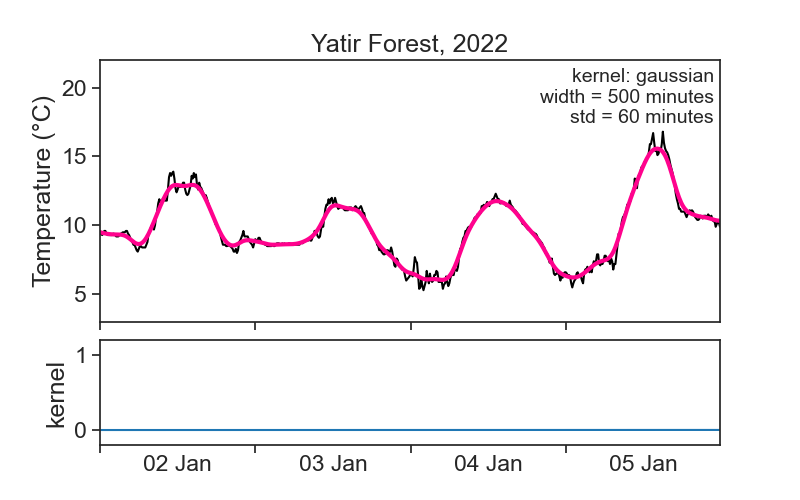

In [29]:
%matplotlib widget
fig, ax = plt.subplots(2, 1, figsize=(8,5), sharex=True,
                       gridspec_kw={'height_ratios':[1,0.4], 'hspace':0.1})

class Lines:
    pass
lines = Lines()

ax0 = ax[0]
ax1 = ax[1]
ylim = [3, 22]
window_width_min = 500.0
window_width_int = int(window_width_min / 10) + 1
N = len(df)
t_swipe = pd.date_range(start=pd.to_datetime(start) - pd.Timedelta(minutes=window_width_min) - pd.Timedelta(minutes=30),
                        end=pd.to_datetime(end) + pd.Timedelta(minutes=60),
                        freq="10min")
t0 = t_swipe[0]
window_middle = t0 + pd.Timedelta(minutes=window_width_min/2)
# fill between blue shade, plot kernel
half_triang = np.arange(1, window_width_int/2+1, 1)
kernel_triang = np.hstack([half_triang, half_triang[-2::-1]])
kernel_triang = kernel_triang / kernel_triang.max()
df['con'] = np.convolve(df['TD'].values, kernel_triang, mode='same') / len(kernel_triang) * 2
df['kernel_plus'] = 0.0
df.loc[t0: t0 + pd.Timedelta(minutes=window_width_min), 'kernel_plus'] = kernel_triang

# array of minutes. multiply by 10 because data is every 10 minutes

std_in_minutes = 60
g = sp.signal.gaussian(window_width_int, std_in_minutes/10)#, sym=True)
df.loc[t0: t0 + pd.Timedelta(minutes=window_width_min), 'kernel_plus'] = g
gaussian_threshold = np.exp(-2**2)  # two sigmas
lines.kernel_line, = ax1.plot(df['kernel_plus'], color="tab:blue")
window_above_threshold = df.loc[df['kernel_plus'] > gaussian_threshold, 'kernel_plus'].index
lines.fill_bet = ax0.fill_between([window_above_threshold[0], window_above_threshold[-1]],
                                           y1=ylim[0], y2=ylim[1], alpha=0.1, zorder=-1, color="tab:blue")

# gaussian convolution from here: https://stackoverflow.com/questions/27205402/pandas-rolling-window-function-offsets-data
df.loc[:, 'con'] = np.convolve(df['TD'].values, g/g.sum(), mode='same')
ax0.plot(df.loc[start:end, 'TD'], color="black")
lines.gray_line, = ax0.plot(df.loc[window_above_threshold[0]:window_above_threshold[-1], 'TD'],
                     color=[0.6]*3, lw=3)
lines.pink_line, = ax0.plot(df.loc[start:window_middle, 'con'], color="xkcd:hot pink", lw=3)
lines.pink_circle, = ax0.plot([window_middle], [df.loc[window_middle, 'con']],
         marker='o', markerfacecolor="None", markeredgecolor="xkcd:dark pink", markeredgewidth=2,
         markersize=8)
ax0.text(0.99, 0.97, f"kernel: gaussian\nwidth = {window_width_min:.0f} minutes\nstd = {std_in_minutes:.0f} minutes", transform=ax0.transAxes,
         horizontalalignment='right', verticalalignment='top',
         fontsize=14)
ax0.set(ylim=ylim,
        xlim=[start, end],
        ylabel="Temperature (°C)",
        yticks=[5,10,15,20],
        title="Yatir Forest, 2022")
ax1.set(ylim=[-0.2, 1.2],
        xlim=[start, end],
        ylabel="kernel"
       )
gauss = df['TD'].rolling(window=window_width_int, center=True, win_type="gaussian").mean(std=6)#, sym=True)
center_dates_two_panels(ax0, ax1)

def update_swipe(k, lines):
    t0 = t_swipe[k]
    window_middle = t0 + pd.Timedelta(minutes=window_width_min/2)
    lines.fill_bet.remove()
    lines.pink_line.set_data(df[start:window_middle].index,
                             df.loc[start:window_middle, 'con'].values)
    lines.pink_circle.set_data([window_middle], [df.loc[window_middle, 'con']])
    lines.kernel_rect = np.ones(window_width_int)
    df['kernel_plus'] = 0.0
    df.loc[t0: t0 + pd.Timedelta(minutes=window_width_min), 'kernel_plus'] = g
    window_above_threshold = df.loc[df['kernel_plus'] > gaussian_threshold, 'kernel_plus'].index
    lines.gray_line.set_data(df.loc[window_above_threshold[0]:window_above_threshold[-1], 'TD'].index,
                             df.loc[window_above_threshold[0]:window_above_threshold[-1], 'TD'].values)
    lines.kernel_line.set_data(df['kernel_plus'].index, df['kernel_plus'].values)
    window_above_threshold = df.loc[df['kernel_plus'] > gaussian_threshold, 'kernel_plus'].index
    lines.fill_bet = ax0.fill_between([window_above_threshold[0], window_above_threshold[-1]],
                                       y1=ylim[0], y2=ylim[1], alpha=0.1, zorder=-1, color="tab:blue")

progress_bar = tqdm(total=len(t_swipe), unit="iteration")
for fignum, i in enumerate(np.arange(0, len(t_swipe)-1, 1)):
    update_swipe(i, lines)
    fig.savefig(f"pngs/gaussian/gaussian_{fignum:03}.png", dpi=600)
    progress_bar.update(1)
# close the progress bar
progress_bar.close()

In [30]:
# Define the path to your PNG images
pngs_path = "pngs/gaussian"
pngs_name = "gaussian_%03d.png"

# Define the output video file path
video_output = "output_gaussian.mp4"

fr = 12
# run command
ffmpeg_cmd = f"ffmpeg -framerate {fr} -i {pngs_path}/{pngs_name} -c:v libx264 -vf fps={fr} {video_output}"
subprocess.run(ffmpeg_cmd, shell=True)

ffmpeg version 6.0 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 14.0.3 (clang-1403.0.22.14.1)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/6.0 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disab

CompletedProcess(args='ffmpeg -framerate 12 -i pngs/gaussian/gaussian_%03d.png -c:v libx264 -vf fps=12 output_gaussian.mp4', returncode=0)

## Comparison

Let's plot in one graph the smoothed temperature for each kernel shape we calculated above (rectangular, triangular, gaussian), all of which with a 500-minute-wide window.

In [9]:
window_width_min = 500.0
window_width_int = int(window_width_min // 10 + 1)

# rectangular, 500 min
kernel_rect = np.ones(window_width_int)
rect = np.convolve(df['TD'].values, kernel_rect, mode='same') / len(kernel_rect)

# triangular
half_triang = np.arange(1, window_width_int/2+1, 1)
kernel_triang = np.hstack([half_triang, half_triang[-2::-1]])
kernel_triang = kernel_triang / kernel_triang.max()
triang = np.convolve(df['TD'].values, kernel_triang, mode='same') / len(kernel_triang) * 2

# gaussian
gauss = df['TD'].rolling(window=window_width_int, center=True, win_type="gaussian").mean(std=6)#, sym=True)


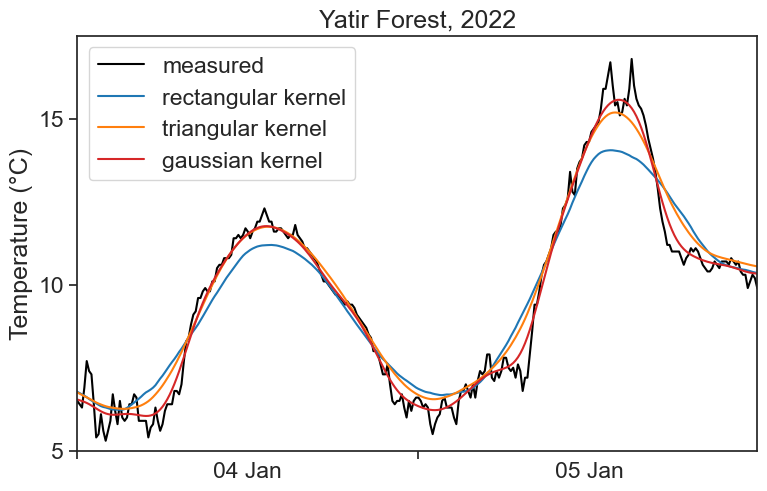

In [13]:
fig, ax = plt.subplots(figsize=(8,5))
ax.figure.subplots_adjust(top=0.93, bottom=0.10, left=0.1, right=0.95)

ax.plot(df.loc[start:end, 'TD'], color='black', label="measured")
ax.plot(df.index, rect, color="tab:blue", label="rectangular kernel")
ax.plot(df.index, triang, color="tab:orange", label="triangular kernel")
ax.plot(df.index, gauss, color="tab:red", label="gaussian kernel")
ax.legend()

ax.set(ylim=[5, 17.5],
       xlim=['2022-01-04 00:00:00', '2022-01-05 23:50:00'],
       ylabel="Temperature (°C)",
       title="Yatir Forest, 2022",
       yticks=[5,10,15])
center_dates(ax)
fig.savefig("kernel_comparison.png")

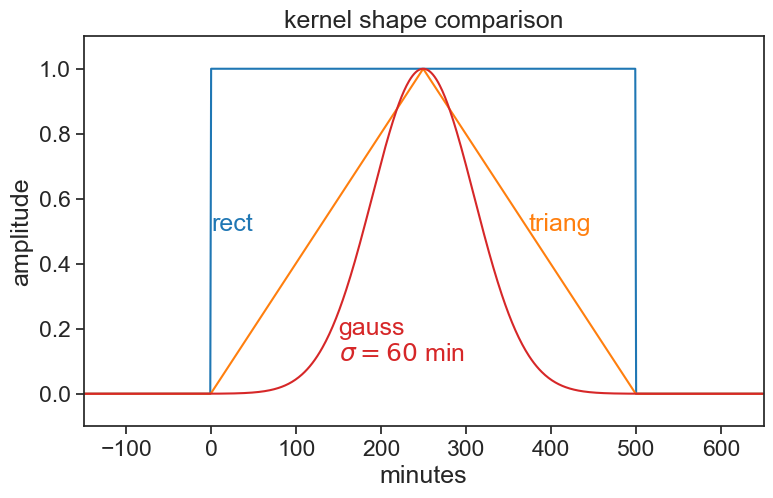

In [10]:
fig, ax = plt.subplots(figsize=(8,5))
ax.figure.subplots_adjust(top=0.93, bottom=0.15, left=0.1, right=0.95)

N=500
rec_window = np.zeros(800)
rec_window[150:150+N] = signal.windows.boxcar(N)
tri_window = np.zeros(800)
tri_window[150:150+N] = signal.windows.triang(N)
gau_window = np.zeros(800)
gau_window[150:150+N] = signal.windows.gaussian(N, std=60)
t = np.arange(-150, 650)
ax.plot(t, rec_window, color="tab:blue")
ax.plot(t, tri_window, color="tab:orange")
ax.plot(t, gau_window, color="tab:red")
ax.text(0, 0.5, "rect", color="tab:blue")
ax.text(373, 0.5, "triang", color="tab:orange")
ax.text(150, 0.1, "gauss\n"+r"$\sigma=60$ min", color="tab:red")
ax.set(ylim=[-0.1, 1.1],
       xlim=[-150, 650],
       ylabel="amplitude",
       xlabel="minutes",
       title="kernel shape comparison",)
fig.savefig("kernel_shapes.png")